# From the Description can we predict the Effects (Multi-Label prediction)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import RandomOverSampler
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix


In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#printmd('**bold**')

In [4]:
df_review=pd.read_excel("../CannaConnect/Dataset/description_clean.xlsx")
df=df_review.Description.astype(str)
df.head()

0     og   hybrid strain pack strong punch name sup...
1     aloha white widow especially potent cut white...
2     sativa dominant hybrid bred spain medical see...
3     dawgs hybrid g chemdawg genetics bred canadia...
4    known kosher tangie k gold  indica dominant hy...
Name: Description, dtype: object

In [5]:
df.shape

(2349,)

In [6]:
EDA=pd.read_excel('../CannaConnect/Dataset/EDA.xlsx')
EDA.head()

,Unnamed: 0,Strain,Type,Rating,Effects,Flavor,Description,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Flavor_1,Flavor_2,Flavor_3,Flavor_4
0,0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus,NaN
1,1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel,NaN
2,2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody,NaN
3,3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit,NaN
4,4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange,NaN


In [7]:
EDA=pd.DataFrame(EDA,columns=['Effect_1','Effect_2','Effect_3','Effect_4','Effect_5'])
EDA.head()

,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5
0,Creative,Energetic,Tingly,Euphoric,Relaxed
1,Relaxed,Aroused,Creative,Happy,Energetic
2,Uplifted,Happy,Relaxed,Energetic,Creative
3,Tingly,Creative,Hungry,Relaxed,Uplifted
4,Happy,Relaxed,Euphoric,Uplifted,Talkative


In [8]:
EDA.fillna('None', inplace = True)

In [9]:
des_type=pd.concat([df,EDA],axis=1)
des_type.head()

,Description,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5
0,og hybrid strain pack strong punch name sup...,Creative,Energetic,Tingly,Euphoric,Relaxed
1,aloha white widow especially potent cut white...,Relaxed,Aroused,Creative,Happy,Energetic
2,sativa dominant hybrid bred spain medical see...,Uplifted,Happy,Relaxed,Energetic,Creative
3,dawgs hybrid g chemdawg genetics bred canadia...,Tingly,Creative,Hungry,Relaxed,Uplifted
4,known kosher tangie k gold indica dominant hy...,Happy,Relaxed,Euphoric,Uplifted,Talkative


In [10]:
mlb=MultiLabelBinarizer()
Y=pd.DataFrame(mlb.fit_transform(des_type[['Effect_1']].values), columns=mlb.classes_, index=des_type.index)
print(Y.head())

   Aroused  Creative  Dry  Energetic  Euphoric  Focused  Giggly  Happy  \
0        0         1    0          0         0        0       0      0   
1        0         0    0          0         0        0       0      0   
2        0         0    0          0         0        0       0      0   
3        0         0    0          0         0        0       0      0   
4        0         0    0          0         0        0       0      1   

   Hungry  None  Relaxed  Sleepy  Talkative  Tingly  Uplifted  
0       0     0        0       0          0       0         0  
1       0     0        1       0          0       0         0  
2       0     0        0       0          0       0         1  
3       0     0        0       0          0       1         0  
4       0     0        0       0          0       0         0  


In [11]:
des_type=pd.concat([df,Y],axis=1)
des_type.head()

,Description,Aroused,Creative,Dry,Energetic,Euphoric,Focused,Giggly,Happy,Hungry,None,Relaxed,Sleepy,Talkative,Tingly,Uplifted
0,og hybrid strain pack strong punch name sup...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,aloha white widow especially potent cut white...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,sativa dominant hybrid bred spain medical see...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,dawgs hybrid g chemdawg genetics bred canadia...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,known kosher tangie k gold indica dominant hy...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
des_type.to_csv('../Cannjoin/Dataset/multiclass-effect.csv')

In [13]:
categories = list(des_type.columns.values)
categories = categories[1:]
print(categories)

['Aroused', 'Creative', 'Dry', 'Energetic', 'Euphoric', 'Focused', 'Giggly', 'Happy', 'Hungry', 'None', 'Relaxed', 'Sleepy', 'Talkative', 'Tingly', 'Uplifted']


In [14]:
counts = []
for category in categories:
    counts.append((category, des_type[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats.head()

,category,number of comments
0,Aroused,38
1,Creative,77
2,Dry,1
3,Energetic,69
4,Euphoric,240


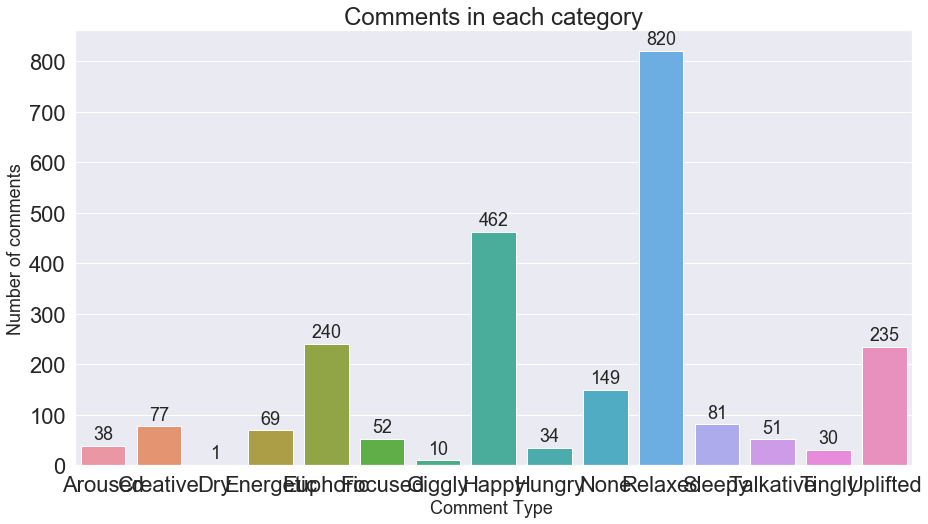

In [15]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, des_type.iloc[:,1:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = des_type.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

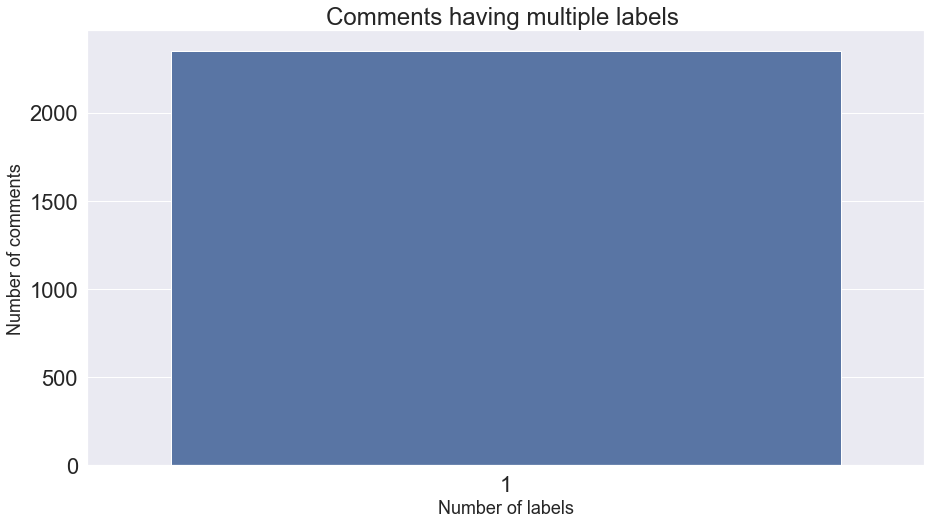

In [16]:
rowSums = des_type.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
#multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)


plt.show()

In [17]:
multiLabel_counts.head()

1    2349
dtype: int64

In [18]:
train, test = train_test_split(des_type, random_state=42, test_size=0.20, shuffle=True)
print(train.shape)
print(test.shape)

(1879, 16)
(470, 16)


In [19]:
train_text = train['Description']
test_text = test['Description']

In [20]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['Description'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['Description'], axis=1)

In [22]:
NB_pipeline = Pipeline([
                #('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(x_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing Aroused
Test accuracy is 0.9829787234042553
... Processing Creative
Test accuracy is 0.9617021276595744
... Processing Dry
Test accuracy is 0.997872340425532
... Processing Energetic
Test accuracy is 0.9744680851063829
... Processing Euphoric
Test accuracy is 0.902127659574468
... Processing Focused
Test accuracy is 0.9765957446808511
... Processing Giggly
Test accuracy is 1.0
... Processing Happy
Test accuracy is 0.8
... Processing Hungry
Test accuracy is 0.9808510638297873
... Processing None
Test accuracy is 0.948936170212766
... Processing Relaxed
Test accuracy is 0.6446808510638298
... Processing Sleepy
Test accuracy is 0.9638297872340426
... Processing Talkative
Test accuracy is 0.9808510638297873
... Processing Tingly
Test accuracy is 0.9872340425531915
... Processing Uplifted
Test accuracy is 0.8957446808510638


In [23]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    printmd('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**Processing Aroused comments...**

Test accuracy is 0.9829787234042553




**Processing Creative comments...**

Test accuracy is 0.9617021276595744




**Processing Dry comments...**

Test accuracy is 0.997872340425532




**Processing Energetic comments...**

Test accuracy is 0.9744680851063829




**Processing Euphoric comments...**

Test accuracy is 0.902127659574468




**Processing Focused comments...**

Test accuracy is 0.9765957446808511




**Processing Giggly comments...**

Test accuracy is 1.0




**Processing Happy comments...**

Test accuracy is 0.8




**Processing Hungry comments...**

Test accuracy is 0.9808510638297873




**Processing None comments...**

Test accuracy is 0.948936170212766




**Processing Relaxed comments...**

Test accuracy is 0.6404255319148936




**Processing Sleepy comments...**

Test accuracy is 0.9638297872340426




**Processing Talkative comments...**

Test accuracy is 0.9808510638297873




**Processing Tingly comments...**

Test accuracy is 0.9872340425531915




**Processing Uplifted comments...**

Test accuracy is 0.8957446808510638


Wall time: 5.23 s


In [24]:
%%time

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.06170212765957447


Wall time: 31.6 s


In [25]:
%%time

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [26]:
%%time

# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.35106382978723405


Wall time: 689 ms


In [27]:
%%time

classifier_new = MLkNN(k=10)

# Note that this classifier can throw up errors when handling sparse matrices.

x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

# train
classifier_new.fit(x_train, y_train)

# predict
predictions_new = classifier_new.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")

Accuracy =  0.09361702127659574


Wall time: 3min 33s
